## Modules

In [1]:
# import basic modules
import pandas as pd
import warnings
import numpy as np
import os

In [2]:
# import all modules related to visualization
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.pyplot import plot
from matplotlib import pyplot
from matplotlib.collections import PolyCollection
from pandas.plotting import autocorrelation_plot
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [3]:
# import all modules related to statistical computing
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import q_stat, acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import jarque_bera
import scipy.stats as stats

In [4]:
# filter warnings
warnings.filterwarnings("ignore")

## Import Training Data & Validation Split

In [5]:
# import the training data and set index as date
training = pd.read_csv(os.getcwd() + "/Data/training.csv")
training["DATE"] = pd.to_datetime(training["DATE"])
training = training.set_index("DATE")

# further split the training data into training and validation sets
training_size = int(len(training) * 0.7)
X_train, X_val = training[0:training_size], training[training_size:]

## Model Evaluation

In [6]:
# pseudo-out-of-sample (in-sample) forecast evaluation for arima models:
# 1. fit model parameters on the training sample and compute the aicc
# 2. produce one-step-ahead forecasts from the end of that sample
# 3. expand the sample to include the next observation, and repeat
# 4. compare forecasts against validation dataset to compute rmse
def evaluate_model(training, validation, order):
    history = [x for x in training.values]
    predictions = list()
    aicc_values = list()
    # iterate over each value in the validation set
    for t in range(len(validation.values)):
        # fit model on training sample
        model = ARIMA(history, order = order)
        model_fit = model.fit()
        aicc_values.append(model_fit.aicc)
        # compute one-step-ahead forecast
        y_hat = model_fit.forecast()[0]
        # append prediction to list
        predictions.append(y_hat)
        # expand the training sample to include next observation and repeat
        history.append(validation.values[t])
    # save original data and fitted values
    rmse = np.sqrt(mean_squared_error(validation, predictions))
    model_data = validation.copy()
    model_data["prediction"] = predictions
    # return the rmse and the fitted values for a given combination of (p,d,q)
    return np.asarray(aicc_values).mean(), rmse, model_data

In [7]:
# grid-search function for finding the best combination of arima parameters (p,d,q)
def grid_search(training, validation, p_grid, d, q_grid):
    best_score, best_cfg = float("inf"), None
    aicc_values = list()
    for p in p_grid:
        for q in q_grid:
            order = (p,d,q)
            try:
                aicc, rmse, model_data = evaluate_model(training, validation, order)
                if aicc < best_score:
                    best_score, rmse, best_cfg, model_data = aicc, rmse, order, model_data
                print("ARIMA%s -> AICc = %.3f" % (order, aicc))
                aicc_values.append(aicc)
            except:
                continue
    # print best model and return best configuration and best scores 
    print("Best ARIMA%s with AICc of %.3f" % (best_cfg, best_score))
    return best_cfg, model_data, aicc_values, rmse

In [8]:
# function for visualization of model training and the corresponding aicc
def plot_model(model_data, aicc, rmse):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16,6))
    
    # plot fitted values from model
    ax1.plot(model_data.iloc[:,0], color = "darkblue", label = "Actual")
    ax1.plot(model_data.iloc[:,1], color = "red", label = "Fitted", linestyle = "-")
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Real GDP Growth")
    ax1.set_title("Fitted Values for best ARIMA Combination (RMSE = %.3f)" % (rmse), loc = "left")
    ax1.tick_params(direction = "in")
    ax1.grid(axis = "y", linewidth = 0.5, linestyle = ":")
    ax1.legend(frameon = False)
    
    # plot aicc values
    ax2.plot(aicc, color = "green")
    ax2.set_xlabel("Grid-Search Iteration")
    ax2.set_ylabel("AICc Value")
    ax2.set_title("Corresponding AICc", loc = "left")
    ax2.tick_params(direction = "in")
    ax2.grid(axis = "y", linewidth = 0.5, linestyle = ":")

In [9]:
# select range of (p,d,q) parameters for grid-search
p, d, q = range(0,6), 0, range(0,3)

In [10]:
# run the grid-search
best_cfg, model_data, aicc_values, rmse = grid_search(X_train, X_val, p, d, q)

ARIMA(0, 0, 0) -> AICc = 679.818
ARIMA(0, 0, 1) -> AICc = 659.023
ARIMA(0, 0, 2) -> AICc = 647.979
ARIMA(1, 0, 0) -> AICc = 650.827
ARIMA(1, 0, 1) -> AICc = 651.440
ARIMA(1, 0, 2) -> AICc = 649.028
ARIMA(2, 0, 0) -> AICc = 650.206
ARIMA(2, 0, 1) -> AICc = 649.993
ARIMA(2, 0, 2) -> AICc = 647.698
ARIMA(3, 0, 0) -> AICc = 648.073
ARIMA(3, 0, 1) -> AICc = 647.779
ARIMA(3, 0, 2) -> AICc = 649.452
ARIMA(4, 0, 0) -> AICc = 648.590
ARIMA(4, 0, 1) -> AICc = 649.801
ARIMA(4, 0, 2) -> AICc = 649.782
ARIMA(5, 0, 0) -> AICc = 648.784
ARIMA(5, 0, 1) -> AICc = 650.298
ARIMA(5, 0, 2) -> AICc = 645.588
Best ARIMA(5, 0, 2) with AICc of 645.588


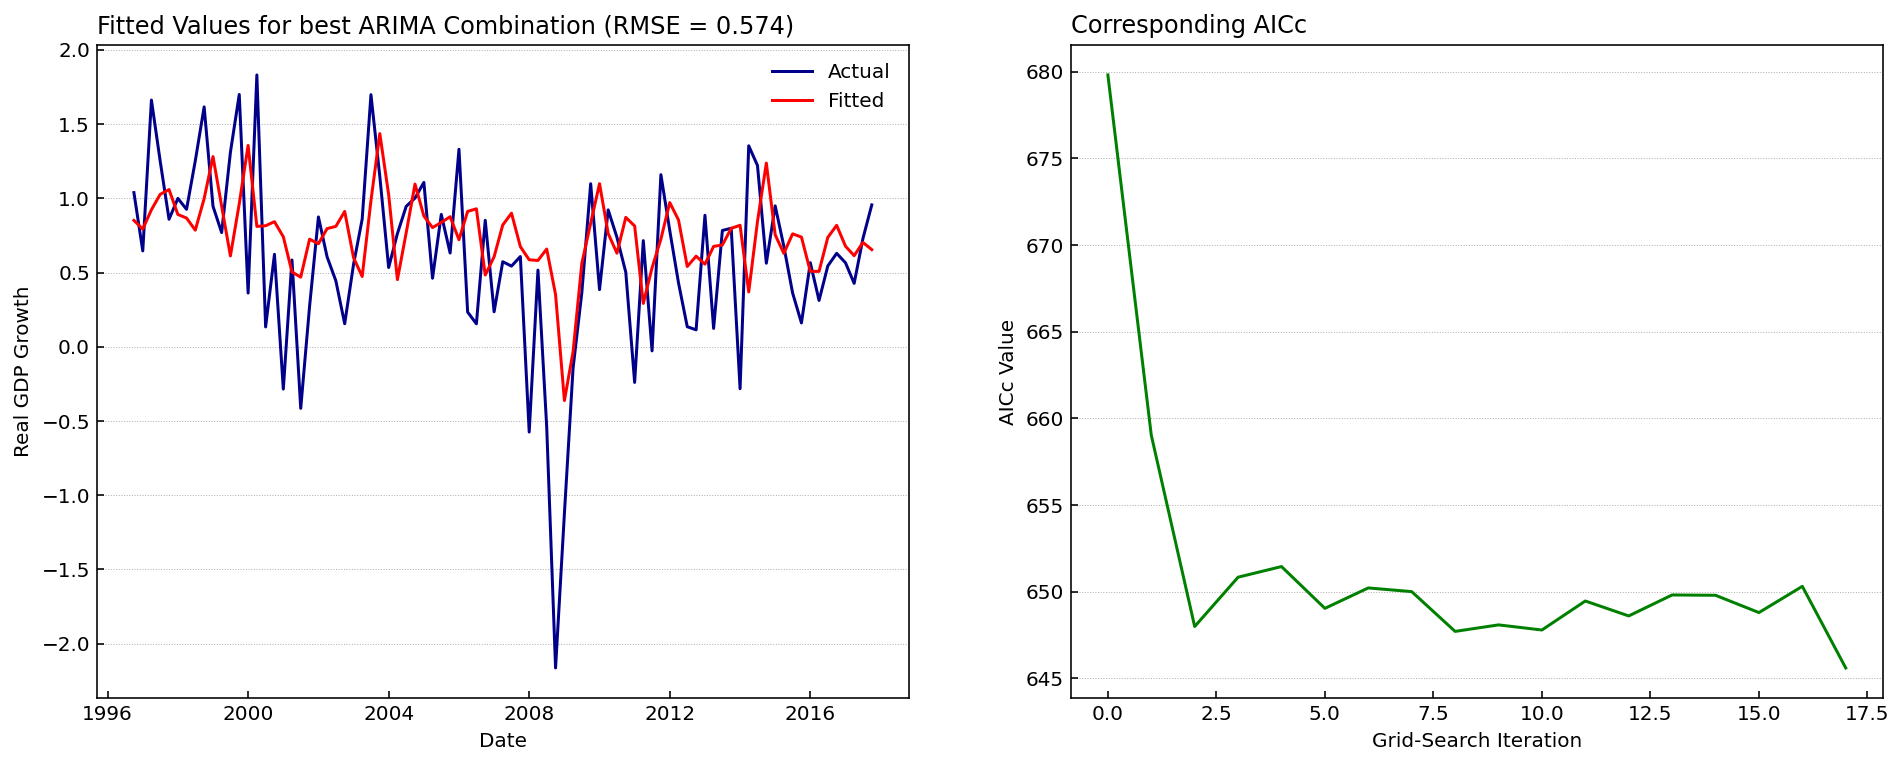

In [11]:
# plot the model training
plot_model(model_data, aicc_values, rmse)

## Residual Diagnostics

In [12]:
# function for visualization of the residuals for the chosen arima model
# good forecasting methods will yield innovation residuals with the following properties:
# 1. The innovation residuals are uncorrelated (otherwise there is information left)
# 2. The innovation residuals have zero mean (otherwise the forecasts are biased)
# 3. The innovation residuals have constant variance (useful, but not necessary)
# 4. The innovation residuals are normally distributed (useful, but not necessary)
def plot_residuals(data, order):
    # get residuals for the chosen combination of (p,d,q) parameters
    model = ARIMA(data, order = order)
    model_fit = model.fit()
    residuals = pd.DataFrame(model_fit.resid)
    
    # distribution plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16,6))
    residuals.plot(kind = "density", ax = ax1, color = "darkblue", legend = False)
    ax1.set_title("Residuals Density with Normal Distribution", loc = "left")
    ax1.tick_params(direction = "in")
    ax1.grid(axis = "y", linewidth = 0.5, linestyle = ":")
    
    # normal distribution
    mean, std = stats.norm.fit(residuals)
    x = np.linspace(-8, 8, 300)
    p = stats.norm.pdf(x, mean, std)
    ax1.plot(x, p, "green")
    ax1.legend(["Residuals", "Normal"], frameon = False)
    ax1.axvline(x = 0, color = "red", linestyle = "--")
    
    # compute the autocorrelation coefficients of the residuals and plot them
    plot_acf(data, ax = ax2, title = "", zero = False, color = "darkblue", 
             alpha = None, lags = 50, use_vlines = True, vlines_kwargs = {"colors": "darkblue"})
    ax2.axhline(y = 2 / np.sqrt(len(data)), color = "red", linestyle = "--")
    ax2.axhline(y = -2 / np.sqrt(len(data)), color = "red", linestyle = "--")
    ax2.set_title("Autocorrelation Function of Residuals", loc = "left")
    ax2.set_xlabel("Lags")
    ax2.set_ylabel("Autocorrelation")
    ax2.tick_params(direction = "in")
    ax2.grid(axis = "y", linewidth = 0.5, linestyle = ":")
    for item in ax2.collections:
        if type(item) == PolyCollection:
            item.set_facecolor("blue")
            
    # return the residual values
    return residuals

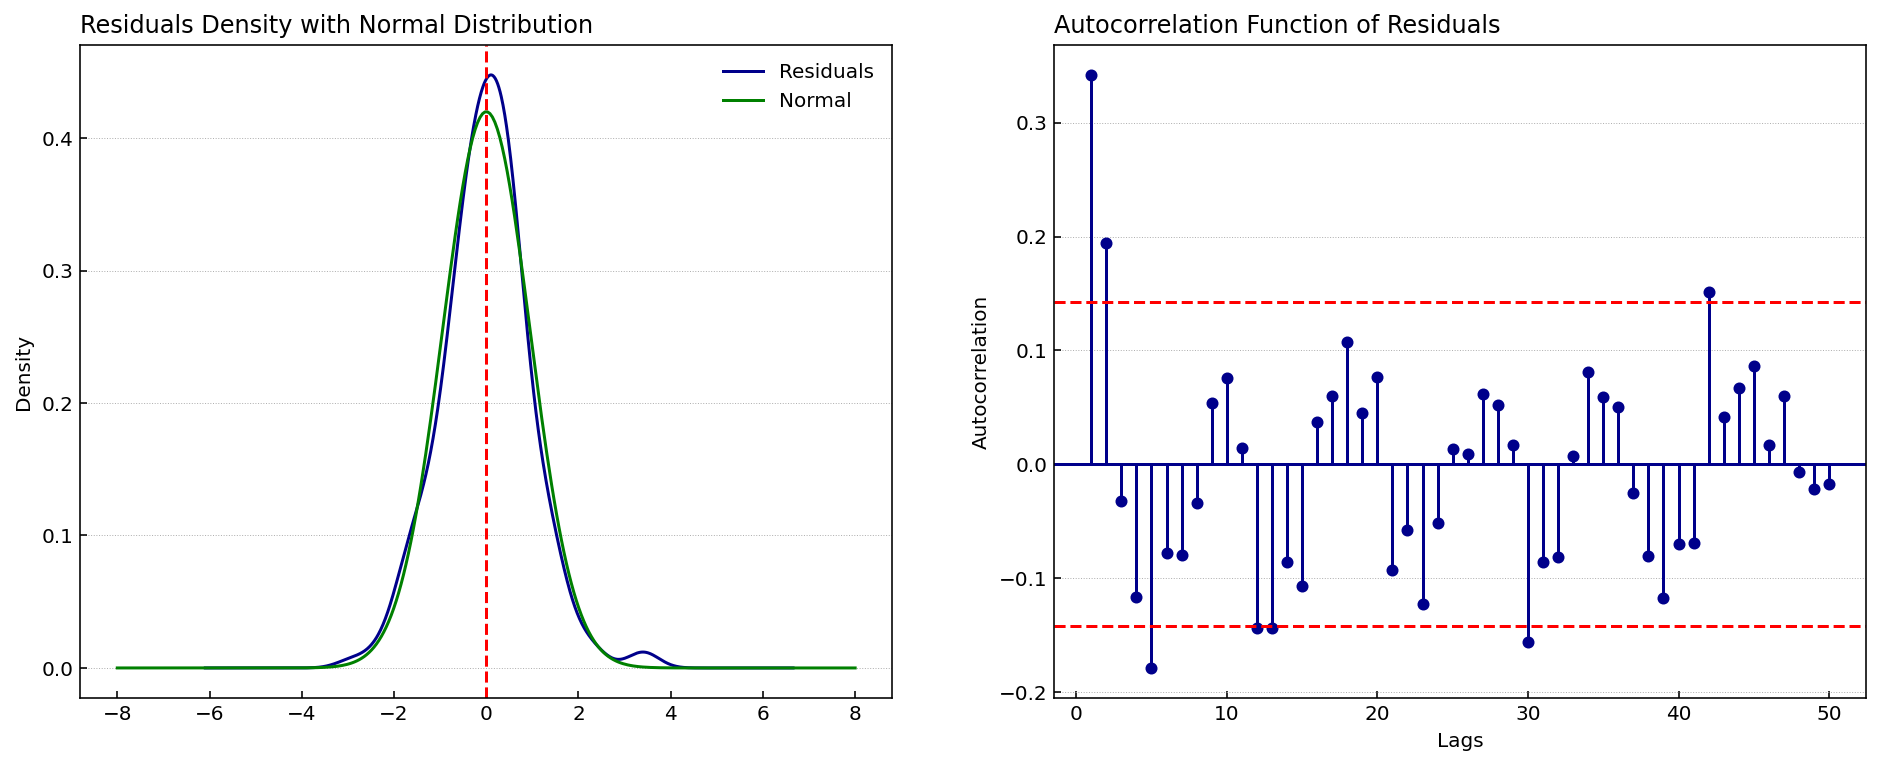

In [13]:
residuals = plot_residuals(X_train, best_cfg)

In [14]:
# Ljung-Box-Q test
# null hypothesis : data is independently distributed (no autocorrelation)
# alternate hypothesis : data is not independently distributed
# reject null hypothesis if p-value <= 0.05
def lbq_test(data):
    lbq_test = acorr_ljungbox(data)
    test_statistic, p_value = lbq_test[0].mean(), lbq_test[1].mean()
    print("Ljung-Box-Q test results")
    print("-> average test statistic: " + str(round(test_statistic, 2)))
    print("-> average p-value: "  + str(round(p_value, 2)))

$$ \text{Test Statistic:} \;\; Q = n(n+2)\sum^{h}_{k=1}\frac{r_{k}^2}{n-k} $$

In [15]:
lbq_test(residuals)

Ljung-Box-Q test results
-> average test statistic: 13.75
-> average p-value: 0.89


In [16]:
# Jarque-Bera test
# null hypothesis : data is normally distributed
# alternate hypothesis : data is not normally distributed
# reject null hypothesis if p-value <= 0.05
def jb_test(data):
    jb_test = jarque_bera(data)
    test_statistic, p_value, skew, kurtosis = jb_test[0].mean(), jb_test[1].mean(), jb_test[2].mean(), jb_test[3].mean()
    print("Jarque-Bera test results")
    print("-> test statistic: " + str(round(test_statistic, 2)))
    print("-> p-value: "  + str(round(p_value, 2)))
    print("-> estimated skew: "  + str(round(skew, 2)))
    print("-> estimated kurtosis: "  + str(round(kurtosis, 2)))

$$ \text{Test Statistic:} \;\; JB = \frac{N}{6}\left( v^2 + \frac{w^2}{4} \right) $$

In [17]:
jb_test(residuals)

Jarque-Bera test results
-> test statistic: 13.16
-> p-value: 0.0
-> estimated skew: 0.2
-> estimated kurtosis: 4.2


## Out-of-Sample Forecast on Test Data

In [18]:
# import the testing data and set index as date
X_test = pd.read_csv(os.getcwd() + "/Data/testing.csv")
X_test["DATE"] = pd.to_datetime(X_test["DATE"])
X_test = X_test.set_index("DATE")

In [19]:
# function for forecasting on test data with chosen arima model
def forecast(training, testing, order):
    model = ARIMA(training, order = order)
    model_fit = model.fit()
    y_hat = model_fit.forecast(steps = len(testing))
    rmse = np.sqrt(mean_squared_error(testing, y_hat))
    print("RMSE = " + str(rmse))
    return y_hat

In [20]:
y_hat = forecast(training, X_test, best_cfg)

RMSE = 0.29188851708986685


In [21]:
# function for visualization of the forecast
def plot_forecast(training, testing, y_hat):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16,6))
    
    ax1.plot(training, color = "darkblue", label = "Training Data")
    ax1.plot(testing, color = "green", label = "Test Data")
    ax1.plot(y_hat, color = "red", label = "Forecasted Values")
    ax1.set_xlabel("Date")
    ax1.set_title("Forecast", loc = "left")
    ax1.legend(frameon = False)
    ax1.tick_params(direction = "in")
    ax1.grid(axis = "y", linewidth = 0.5, linestyle = ":")
    
    ax2.plot(testing, color = "green")
    ax2.plot(y_hat, color = "red")
    ax2.set_xlabel("Date")
    ax2.set_title("Forecast (zoomed-in)", loc = "left")
    ax2.tick_params(direction = "in")
    ax2.grid(axis = "y", linewidth = 0.5, linestyle = ":")

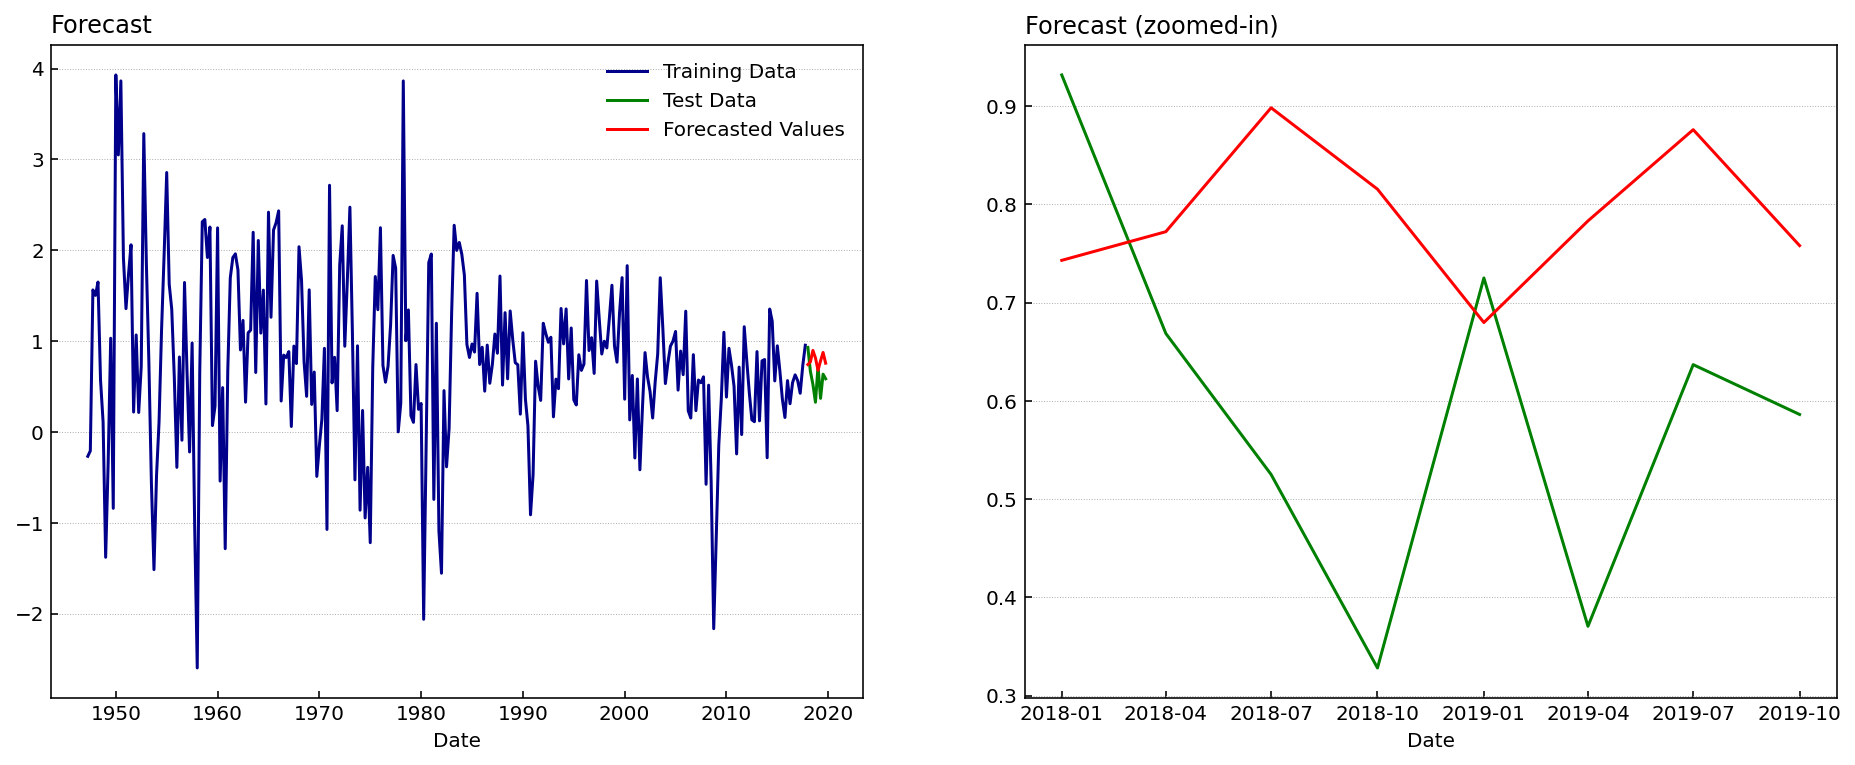

In [22]:
plot_forecast(training, X_test, y_hat)